In [1]:
import glob
import itertools
import os
import random

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sn

plt.style.use("ggplot")

# Explore differences in alkalinity

Within Tiltaksovervakingen, we have noticed a big difference between alkalinity values reported by different labs. In particular, the distribution of values reported by Eurofins seems to be substantially lower than the data distribution from other labs. As an example, see the distribution plots [here](https://nivanorge.github.io/tiltaksovervakingen/output/eurofins_2024_q2_v1/distribution_plots_vegalite5.html). Distributions of values reported by NIVA and Vestfoldlab are broadly similar for the historic period, while Eurofins values are typically lower. On the Q-Q plots linked above, around two-thirds of the Eurofins data are at or below the limit of detection (LOD; 0.03 mmol/l), whereas the 66th percentile of the historic data (which mostly comes from NIVA and Vestfoldlab) is nearly 0.07.

NIVAlab has previously compared results for alkalinity with those from Eurofins and broadly the same patterns have been observed - see e-mail forwarded by Øyvind K on 30.10.2024 for details.

This notebook explores the alkalinity results in a little more detail.

## 1. Get historic data from Vannmiljø

Get all `ALK` data for sites within Tiltaksovervakingen since 1990.

In [2]:
# Define parameters and time period of interest
pars = ["ALK", "PH", "CA"]
st_yr, end_yr = 1990, 2024

In [3]:
# Get data from Vannmiljø API
tiltak_stn_df = pd.read_excel(r"../data/active_stations_2020.xlsx", sheet_name="data")
filter_dict = {
    "WaterLocationCodeFilter": tiltak_stn_df["vannmiljo_code"].tolist(),
    "FromDateSamplingTime": f"{st_yr}-01-01",
    "ToDateSamplingTime": f"{end_yr}-12-31",
    "ParameterIDFilter": pars,
    "FromRegDate": "1900-01-01",
}
vm_df = nivapy.da.post_data_to_vannmiljo("GetRegistrations", data=filter_dict)
vm_df = vm_df.query("MediumID == 'VF'")
vm_df = vm_df.query("ActivityID in ('KALK', 'KALL')")

# Split station details from chem and tidy
stn_col_dict = {
    "WaterLocationCode": "station_code",
    "Name": "station_name",
    "CoordX": "utm33_east",
    "CoordY": "utm33_north",
    "WaterCategory": "type",
    "VassdragsomradeID": "vassom_id",
    "Vassdragsomrade": "vassom_name",
    "WaterBodyID": "waterbody_id",
    "WaterBody": "waterbody_name",
    "VannomradeID": "vannom_id",
    "Vannomrade": "vannom_name",
    "VannregionID": "vannreg_id",
    "Vannregion": "vannreg_name",
    "Fylke": "fylke",
    "Kommune": "kommune",
}
stn_df = (
    vm_df[stn_col_dict.keys()].copy().rename(columns=stn_col_dict).drop_duplicates()
)
assert stn_df["station_code"].is_unique

wc_col_dict = {
    "WaterLocationCode": "station_code",
    "ActivityID": "activity_id",
    "ActivityName": "activity_name",
    "Employer": "employer",
    "Contractor": "contractor",
    "SamplingTime": "sampling_date",
    "UpperDepth": "upper_depth",
    "LowerDepth": "lower_depth",
    "ParameterID": "parameter",
    "ValueOperator": "flag",
    "RegValue": "value",
    "Unit": "unit",
}
vm_df = vm_df[wc_col_dict.keys()].copy().rename(columns=wc_col_dict)
vm_df = vm_df.query("flag != '>'")
vm_df["par_unit"] = vm_df["parameter"] + "_" + vm_df["unit"]
vm_df["par_unit"] = vm_df["par_unit"].str.replace("/", "p")
vm_df["par_unit"] = vm_df["par_unit"].str.replace(" ", "")
del vm_df["parameter"], vm_df["unit"], vm_df["flag"]
vm_df["sampling_date"] = pd.to_datetime(vm_df["sampling_date"])
id_cols = ["station_code", "contractor", "sampling_date", "par_unit"]
vm_df = vm_df[id_cols + ["value"]]

# Average duplicates
vm_df = vm_df.groupby(id_cols).mean().unstack("par_unit")
vm_df.columns = [
    col.replace("_<ubenevnt>", "") for col in vm_df.columns.get_level_values(1)
]
vm_df = vm_df.reset_index().dropna(subset="ALK_mmolpl")

vm_df.head()

,station_code,contractor,sampling_date,ALK_mmolpl,CA_mgpl,PH
185,002-58798,NIVA,2014-09-01,0.055,2.020,5.57
188,002-58798,NIVA,2014-10-06,0.060,1.930,5.70
190,002-58798,NIVA,2014-11-03,0.020,0.859,4.89
192,002-58798,NIVA,2014-12-01,0.032,1.060,5.14
195,002-58798,NIVA,2015-03-02,0.077,2.010,5.71


In [4]:
# Count samples analysed by each lab in the historic data
contractor_counts = vm_df["contractor"].value_counts()
contractor_counts

contractor
NIVA                                             5206
VestfoldLAB AS                                   3836
Telelab                                           219
West Lab Services AS                               26
RF-Miljølab                                        16
Eurofins Environment Testing Norway AS (Moss)      13
Rådgivende Biologer AS                             10
UKJENT                                              8
KMLab                                               7
Eurofins Norsk Miljøanalyse                         6
Intertek West Lab AS                                6
Agderforsk                                          4
Intertek West Lab AS                                4
Alcontrol                                           3
NINA                                                2
NMT-Dalane                                          1
Fjellab, Rjukan                                     1
ADH-vannlaboratoriet                                1
Espen Enge       

In [5]:
# Only consider the main labs involved
# This keep the analysis simple and makes stats. more robust
samp_thresh = 100
main_contractors = list(contractor_counts[contractor_counts > samp_thresh].index)
print(f"The following labs have more the {samp_thresh} samples in the historic data:")
print(main_contractors)
vm_df = vm_df.query("contractor in @main_contractors")

The following labs have more the 100 samples in the historic data:
['NIVA', 'VestfoldLAB AS', 'Telelab']


## 2. Read recent data from Eurofins

The recent `ALK` data from Eurofins has been excluded from Vannmiljø due to concerns over data quality. The code below therefore reads Eurofins `ALK` results since September 2020 directly from the raw data templates.

In [6]:
# Read data from Eurofins templates
search_path = r"../data/eurofins_data_*.xlsx"
flist = sorted(glob.glob(search_path))
df_list = []
for fpath in flist:
    # Use latest version of each file
    if (os.path.basename(fpath).split("_")[-1] == "v1.xlsx") and (
        fpath.replace("_v1", "_v2") in flist
    ):
        print("Skipping", fpath, "as newer version exists.")
        continue
    eur_df = pd.read_excel(
        fpath,
        sheet_name="results",
        skiprows=3,
        usecols="C,G,J,L,W",
        header=None,
    )
    eur_df.columns = ["station_code", "sampling_date", "PH", "ALK_mmolpl", "CA_mgpl"]
    for col in ["PH", "ALK_mmolpl", "CA_mgpl"]:
        eur_df[col] = (
            eur_df[col]
            .astype(str)
            .str.replace("<", "")
            .str.replace(",", ".")
            .astype(float)
        )
    eur_df["contractor"] = "Eurofins"
    eur_df.groupby(["station_code", "contractor", "sampling_date"]).mean().reset_index()
    eur_df = eur_df.dropna(subset="ALK_mmolpl")
    df_list.append(eur_df)
eur_df = pd.concat(df_list, axis="rows")
eur_df.head()

Skipping ../data/eurofins_data_2021_q1_v1.xlsx as newer version exists.
Skipping ../data/eurofins_data_2021_q2_v1.xlsx as newer version exists.
Skipping ../data/eurofins_data_2021_q3_v1.xlsx as newer version exists.
Skipping ../data/eurofins_data_2021_q4_v1.xlsx as newer version exists.


,station_code,sampling_date,PH,ALK_mmolpl,CA_mgpl,contractor
4,023-45835,2020-09-08 07:15:11,6.1,0.018,0.96,Eurofins
5,023-45835,2020-10-07 07:20:55,5.9,0.010,1.00,Eurofins
6,023-45835,2020-11-04 07:10:49,5.6,0.010,0.85,Eurofins
7,023-45835,2020-12-09 07:20:54,5.5,0.010,0.67,Eurofins
12,023-58885,2020-09-08 07:15:11,6.2,0.028,1.30,Eurofins


## 3. Combine datasets

In [7]:
# Combine datasets from Eurofins and Vannmiljø
df = pd.concat([vm_df, eur_df], axis="rows")

# Average duplicates
df = df.groupby(["station_code", "contractor", "sampling_date"]).mean().reset_index()
df.head()

,station_code,contractor,sampling_date,ALK_mmolpl,CA_mgpl,PH
0,002-105961,Eurofins,2022-04-06,0.129,3.6,6.3
1,002-105961,Eurofins,2022-05-03,0.018,1.4,5.6
2,002-105961,Eurofins,2022-06-08,0.030,1.8,5.9
3,002-105961,Eurofins,2022-07-06,0.030,2.1,5.5
4,002-105961,Eurofins,2022-08-03,0.060,2.7,6.2


## 4. Explore data

### 4.1. Lab analysis periods

In [8]:
# Check data ranges
df.groupby("contractor")[["sampling_date", "ALK_mmolpl"]].agg(
    ["count", "min", "mean", "max"]
)

sampling_date                      \
                       count                 min   
contractor                                         
Eurofins                4491 2020-09-01 07:20:15   
NIVA                    5206 1994-09-25 00:00:00   
Telelab                  219 1999-03-01 00:00:00   
VestfoldLAB AS          3836 2011-03-14 00:00:00   

                                                        ALK_mmolpl         \
                                        mean        max      count    min   
contractor                                                                  
Eurofins       2022-07-17 01:09:16.754174976 2024-06-30       4491  0.010   
NIVA           2013-10-13 16:34:40.061467648 2016-01-16       5206 -0.014   
Telelab        1999-07-06 00:13:09.041095936 1999-12-29        219  0.000   
VestfoldLAB AS 2017-12-10 08:11:23.211678976 2020-08-03       3836  0.005   

                                 
                    mean    max  
contractor                       
Eurofins        0.039318  6.100  
NIVA            0.060672  1.576  
Telelab         0.044941  0.391  
VestfoldLAB AS  0.061078  0.710

The output above shows that NIVAlab analysed data from 1994 to 2016 (more than 5k samples), except during 1999 when Telelab seems to have taken responsibility (~200 samples). It seems that VestfoldLAB has done most of the analysis from 2011 to August 2020 (3.8k samples), and then Eurofins takes over from September 2020 to the present day (4.5k samples). This seems sensible based on my understanding of the monitoring programme. 

### 4.2. Overall data distributions

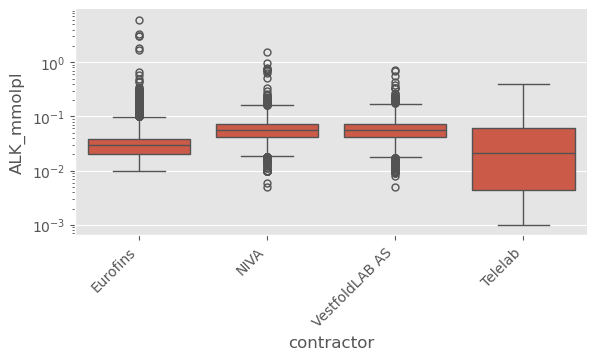

In [9]:
# Overall data distributions by lab
g = sn.catplot(
    data=df,
    x="contractor",
    y="ALK_mmolpl",
    kind="box",
    height=3,
    aspect=2,
    log_scale=True,
)
g.set_xticklabels(rotation=45, ha="right")

Distributions from NIVAlab and VestfoldLAB are similar, whereas results from Eurofins are substantially lower (**note the log scale on the y-axis**). Results from Telelab have high variance (and also some very low values), but I won't consider these further as the dataset is much more limited and it's a long time ago (just one year of data, in 1999).

### 4.3. Q-Q plots

The plots below show data values from each lab for a range of percentiles from the 5th to the 95th. I have clipped values less than p05 and greater than p95, because all labs occasionally report extreme outliers, which skew the plots and make them difficult to read. Such outliers are usually due to contaminated samples or errors during the analysis. They therefore do not reflect the labs' typical performance, so I think it is more meaningful to exclude them.

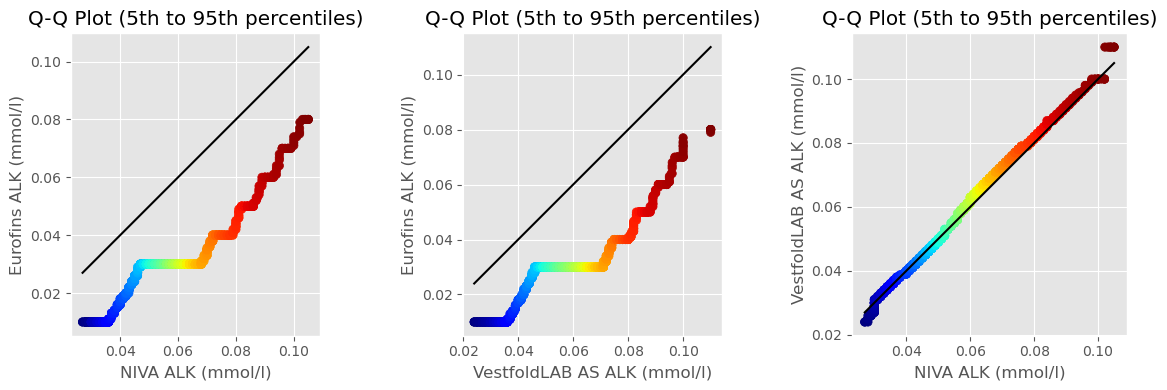

In [10]:
# Data pairs to compare (lab_x, lab_y)
pairs = [
    ("NIVA", "Eurofins"),
    ("VestfoldLAB AS", "Eurofins"),
    ("NIVA", "VestfoldLAB AS"),
]

# Plot
fig, axes = plt.subplots(1, len(pairs), figsize=(12, 4))
quants = np.arange(5, 95, 0.1)
for ax, pair in zip(axes, pairs):
    lab_x, lab_y = pair
    vals_x = df.query("contractor == @lab_x")["ALK_mmolpl"].dropna()
    vals_y = df.query("contractor == @lab_y")["ALK_mmolpl"].dropna()
    quant_x = np.percentile(vals_x, quants)
    quant_y = np.percentile(vals_y, quants)

    ax.scatter(x=quant_x, y=quant_y, c=quants, cmap="jet")
    ax.plot(
        [quant_x.min(), quant_x.max()],
        [quant_x.min(), quant_x.max()],
        "k-",
    )
    ax.set_title(f"Q-Q Plot (5th to 95th percentiles)")
    ax.set_xlabel(f"{lab_x} ALK (mmol/l)")
    ax.set_ylabel(f"{lab_y} ALK (mmol/l)")
    ax.set_aspect("equal", adjustable="box")
plt.tight_layout()

It is clear from the plots above that Eurofins ALK values are consistently lower than either NIVAlab or VestfoldLAB. A large proportion of the Eurofins results are at or below the LOD. By contrast, VestfoldLAB and NIVAlab consistently report valøues above the LOD.

In general, there is a good agreement in the distribution of values reported by NIVAlab and VestfoldLAB (right-most plot above). However, the highest values reported by NIVAlab (i.e. >p95) are higher than anything measured by VestfoldLAB. NIVA values range up to about 1.6 mmol/l, whereas the maximum ALK in the VestfoldLAB data is about 0.7 mmol/l. This is consistent with Tina's comment that ALK values measured by NIVAlab are typically higher than results from other labs in comparison tests. Note that there are 4 samples from Eurofins with ALK values in the range from 3 to 6 mmol/l, but I assume these are either contaminated samples or due to errors in the analysis).

**Based on this comparison, the Eurofins data clearly stands out compared to data from NIVA and VestfoldLAB**.

### 4.4. Results for single sites

The code below selects a random site with good monitoring data and plots the ALK values over time, coloured according to the lab performing the analysis. This is repeated several times for different sites.

In [11]:
# Limit choice to stations with lots of data (> 'stn_samp_thresh' samples)
stn_samp_thresh = 150
stn_samp_counts = df["station_code"].value_counts()
main_stns = list(stn_samp_counts[stn_samp_counts > stn_samp_thresh].index)

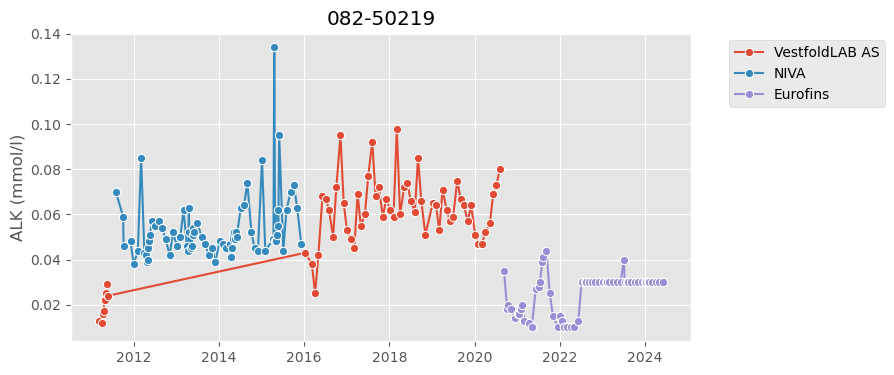

In [12]:
# Plot data for a random station
stn_id = random.choice(main_stns)
stn_df = df.query("station_code == @stn_id").sort_values("sampling_date").copy()
plt.figure(figsize=(8, 4))
sn.lineplot(
    data=stn_df, x="sampling_date", y="ALK_mmolpl", hue="contractor", marker="o"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylabel("ALK (mmol/l)")
plt.xlabel("")
plt.title(stn_id);

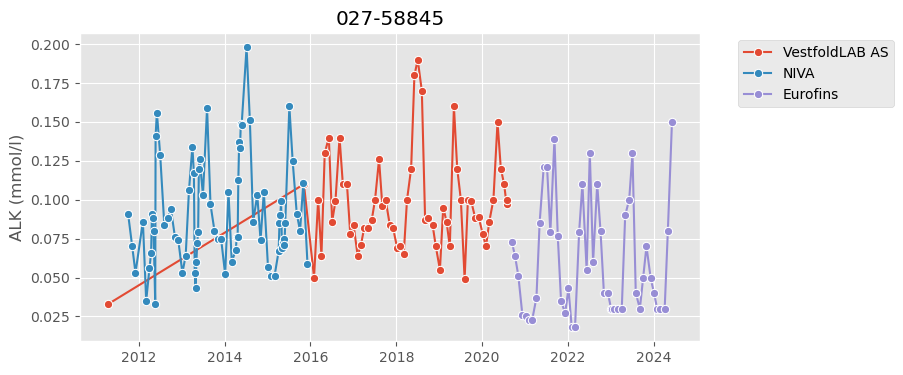

In [13]:
# Plot data for a random station
stn_id = random.choice(main_stns)
stn_df = df.query("station_code == @stn_id").sort_values("sampling_date").copy()
plt.figure(figsize=(8, 4))
sn.lineplot(
    data=stn_df, x="sampling_date", y="ALK_mmolpl", hue="contractor", marker="o"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylabel("ALK (mmol/l)")
plt.xlabel("")
plt.title(stn_id);

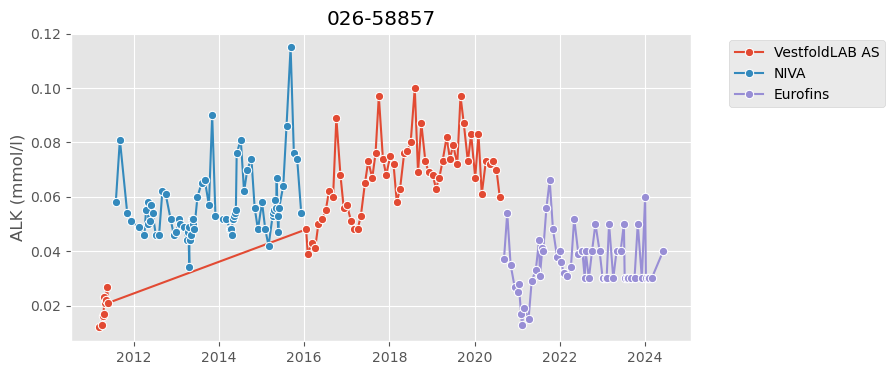

In [14]:
# Plot data for a random station
stn_id = random.choice(main_stns)
stn_df = df.query("station_code == @stn_id").sort_values("sampling_date").copy()
plt.figure(figsize=(8, 4))
sn.lineplot(
    data=stn_df, x="sampling_date", y="ALK_mmolpl", hue="contractor", marker="o"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylabel("ALK (mmol/l)")
plt.xlabel("")
plt.title(stn_id);

Based on these examples, note the following:

 * There is no obvious step-change when switching from NIVAlab to VestfoldLAB in 2016.

 * There is a very obvious step-change when switching from VestfoldLAB to Eurofins in 2020.

 * The Eurofins data from mid-2022 onwards is almost always at the LOD (0.03 mmol/l).

 * The VestfoldLAB values from 2011 are often low. In fact, they're broadly compatible with the recent data from Eurofins. It would be interesting to know what methodological changes occurred at VestfoldLAB between 2011 and 2016.

### 4.5. Comparison to Ca and pH

See e-mail from Øyvind received 31.10.2024.

In [15]:
# Remove Telelab
df = df.query("(contractor != 'Telelab')")

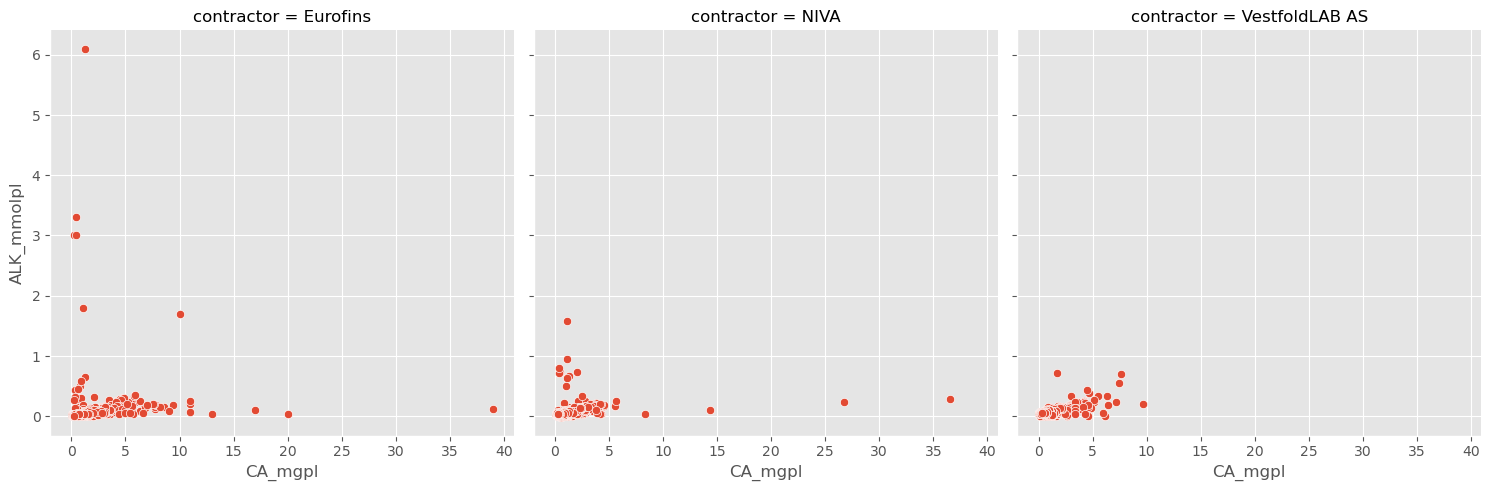

In [16]:
# ALK vs Ca using all data
sn.relplot(data=df, x="CA_mgpl", y="ALK_mmolpl", col="contractor")

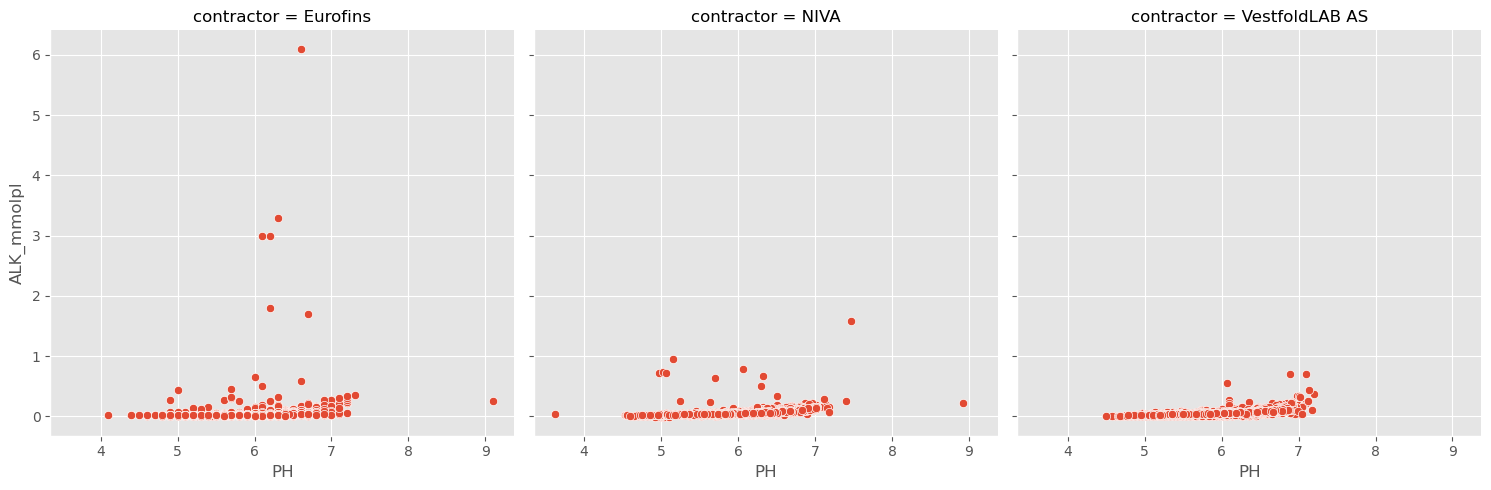

In [17]:
# ALK vs pH using all data
sn.relplot(data=df, x="PH", y="ALK_mmolpl", col="contractor")

The relationships on these plots are hard to see, as a small number of extreme outliers causes the axis scales to be compressed. The plots below show the same data, but filtered to only include samples where the ALK, Ca and pH values are within the range p01 to p99 (i.e. clipping the upper and lower 1% of values for each variable). This makes core relationship easier to see.

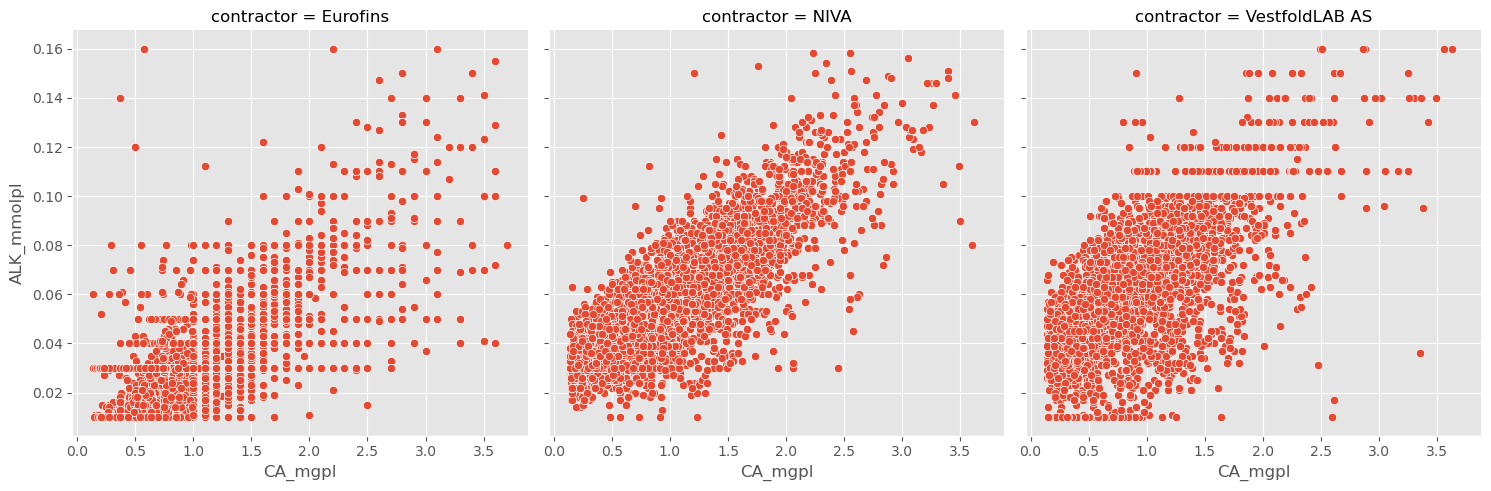

In [18]:
alk_p01, alk_p99 = np.percentile(df["ALK_mmolpl"], (1, 99))
ca_p01, ca_p99 = np.percentile(df["CA_mgpl"].dropna(), (1, 99))
ph_p01, ph_p99 = np.percentile(df["PH"].dropna(), (1, 99))
df_clip = df.query(
    "(@alk_p01 <= ALK_mmolpl <= @alk_p99) and "
    "(@ca_p01 <= CA_mgpl <= @ca_p99) and "
    "(@ph_p01 <= PH <= @ph_p99)"
)
sn.relplot(data=df_clip, x="CA_mgpl", y="ALK_mmolpl", col="contractor")

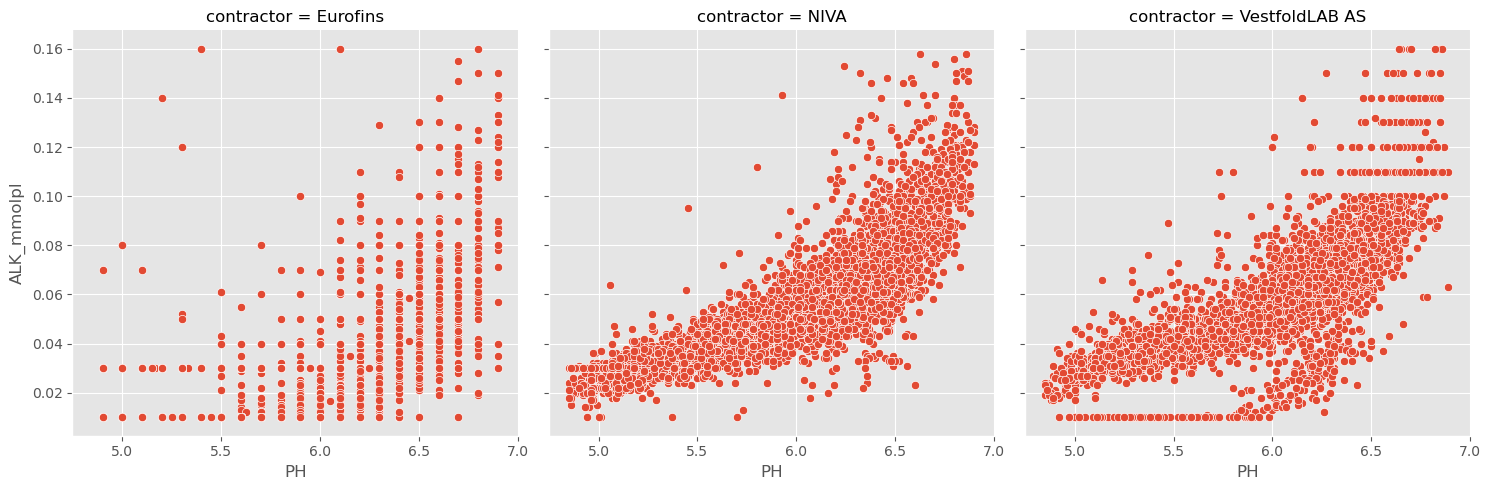

In [19]:
sn.relplot(data=df_clip, x="PH", y="ALK_mmolpl", col="contractor")